# Data Science Society Kmeans clustering (solutions)

## Debugging problems

### 1) Read in the data and transform it for clustering

Read in the whole dataset as we did before but now focusing on the five columns of: 
- residential_pop
- class_1_pop
- WZ_area_pop
- transport_nearby
- stores_nearby

Transform and standardise the data ready for clustering analysis

In [1]:
#import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import contextily as cx

In [2]:
#read in the stores dataset
#it is a geographic dataset so we need to use
#geopandas
London_convenience_stores = gpd.read_file("Data/Convenience_stores_dataset.gpkg",
                              driver = "GPKG")

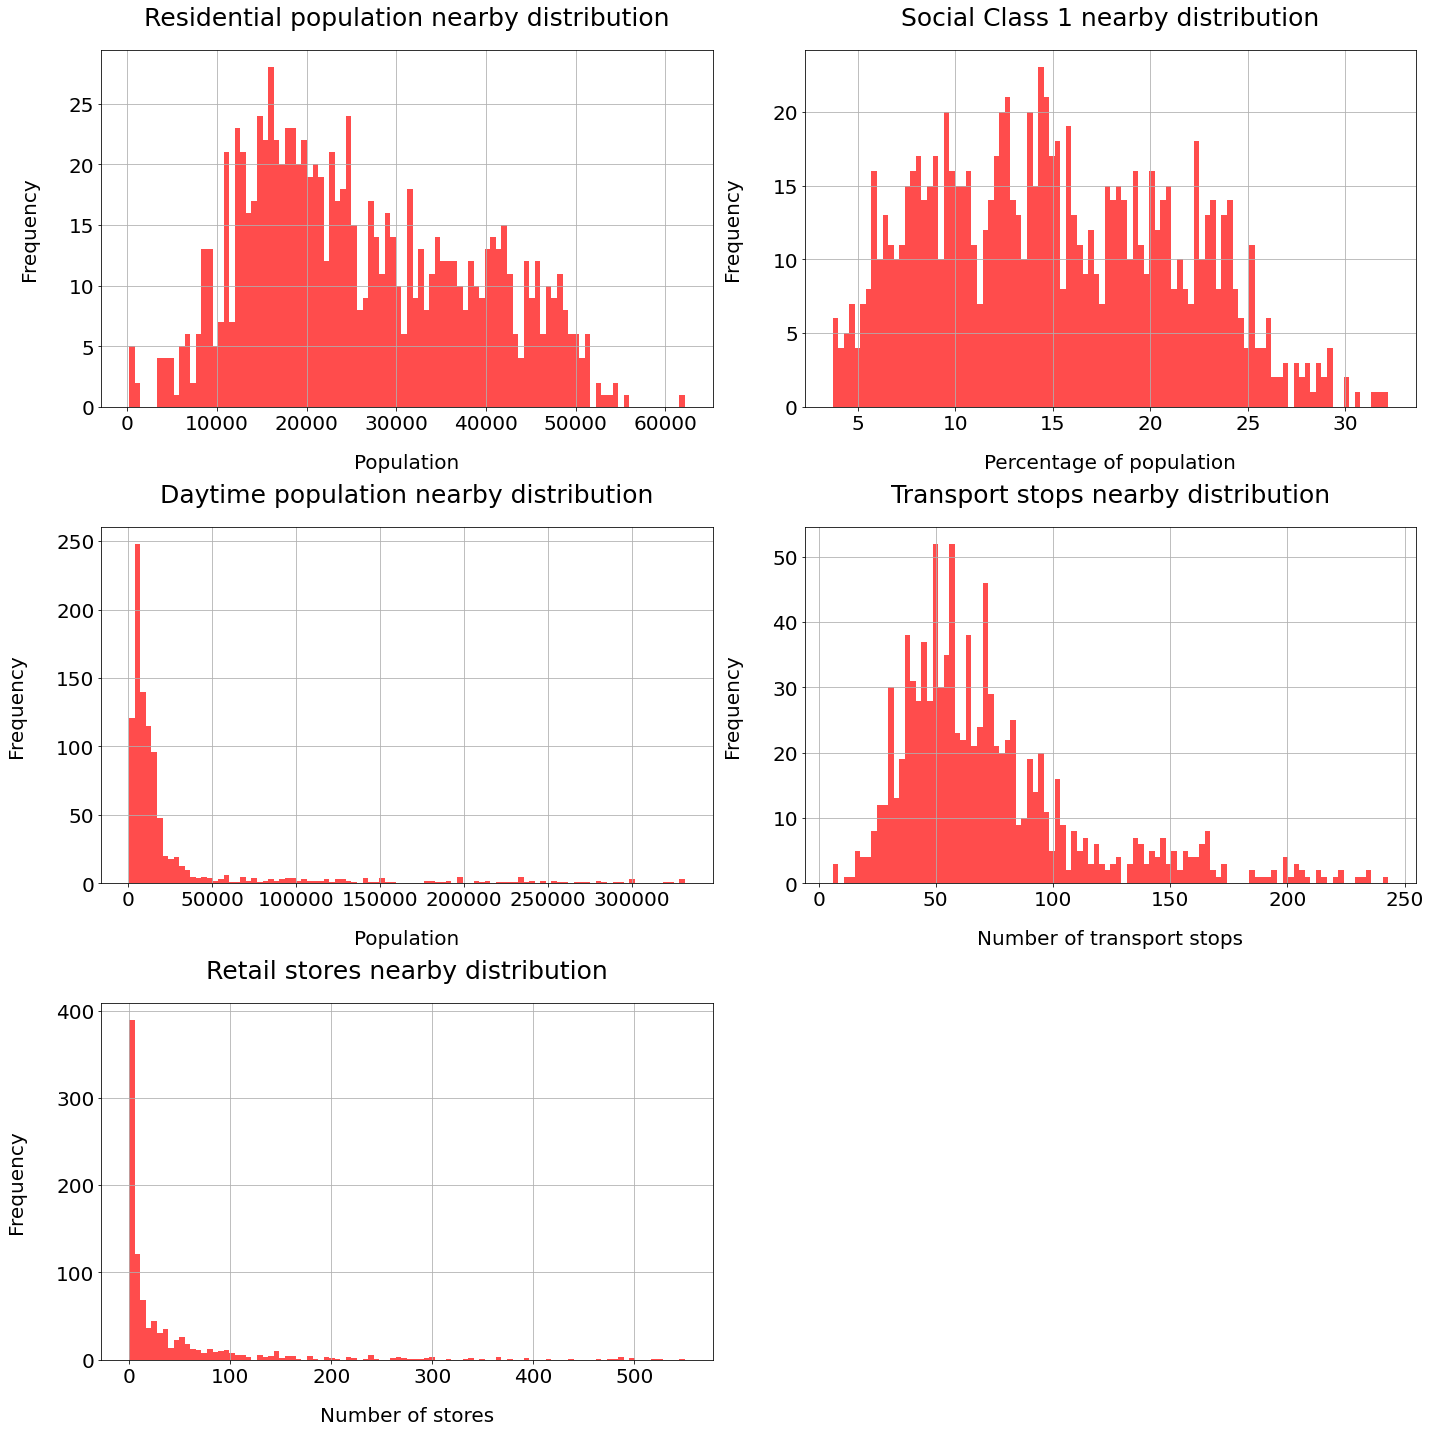

In [3]:
#set the columns we are interested in
columns = ["residential_pop", 
            "class_1_pop",
            "WZ_area_pop",
            "transport_nearby",
            "stores_nearby"]
#set the histogram titles
hist_titles = ["Residential population nearby distribution",
              "Social Class 1 nearby distribution",
              "Daytime population nearby distribution",
              "Transport stops nearby distribution",
              "Retail stores nearby distribution"]
#set the acis labels
axis_labels = ["Population", 
              "Percentage of population",
              "Population",
              "Number of transport stops",
              "Number of stores"]

#create a base axis for teh plots
fig, ax = plt.subplots(3,2, figsize = (20,20))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(columns):
    
    #create the histogram using the column
    London_convenience_stores[col].hist(bins = 100, ax = axis[i],
                                       color = "red",
                                       alpha = 0.7)
    #add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20)

#remove the unused axis
axis[5].set_axis_off()
#keep the layout tight
plt.tight_layout()
#show the plot 

In [4]:
#understand the data distribution to see if tehre will be any issues in trasnformation
London_convenience_stores[["residential_pop", 
                            "class_1_pop",
                            "WZ_area_pop",
                            "transport_nearby",
                            "stores_nearby"]].describe()

,residential_pop,class_1_pop,WZ_area_pop,transport_nearby,stores_nearby
count,997.000000,997.000000,997.000000,997.000000,997.000000
mean,26071.210934,15.097149,30121.558033,73.462387,43.041123
std,12365.566244,6.199306,57284.082592,40.481488,81.752438
min,214.115750,3.699248,509.041464,6.000000,0.000000
25%,16142.481285,9.948477,5432.286653,47.000000,2.000000
50%,23947.206728,14.591609,10121.444254,63.000000,10.000000
75%,35795.200538,20.056803,18482.048663,87.000000,45.000000
max,62169.485840,32.193807,331357.322734,243.000000,550.000000


In [5]:
#iteratre over the columns
for col in columns:
    #create a new log column and convert the data
    London_convenience_stores[col + "_log"] = np.log10(London_convenience_stores[col] + 1)
    #some issues are encountered so convert these to 0 values 
    London_convenience_stores[col + "_log"] = London_convenience_stores[col + "_log"].replace([np.inf, -np.inf], 0)

In [6]:
#import preprocessing
from sklearn.preprocessing import StandardScaler
#scale the data accordingly
scaled = London_convenience_stores[["residential_pop_log", 
                                "class_1_pop_log",
                                "WZ_area_pop_log",
                                "transport_nearby_log",
                                "stores_nearby_log"]].copy()

#use the standard scaler
sc = StandardScaler()

#implement the scaling
for col in scaled.columns:
    scaled[col] = sc.fit_transform(scaled[col].values.reshape(-1,1))

#create a dataframe from the data
log_then_normal = pd.DataFrame(scaled)

#set the columns 
log_columns = ["residential_pop_log", 
               "class_1_pop_log", 
               "WZ_area_pop_log", 
               "transport_nearby_log", 
               "stores_nearby_log"]

#set the column names
log_then_normal.columns = log_columns

#add this to a scaled dataset to be used in modelling
London_convenience_stores_scaled = pd.concat([London_convenience_stores.drop(log_columns, axis = 1), 
                                              log_then_normal], 
                                             axis = 1)

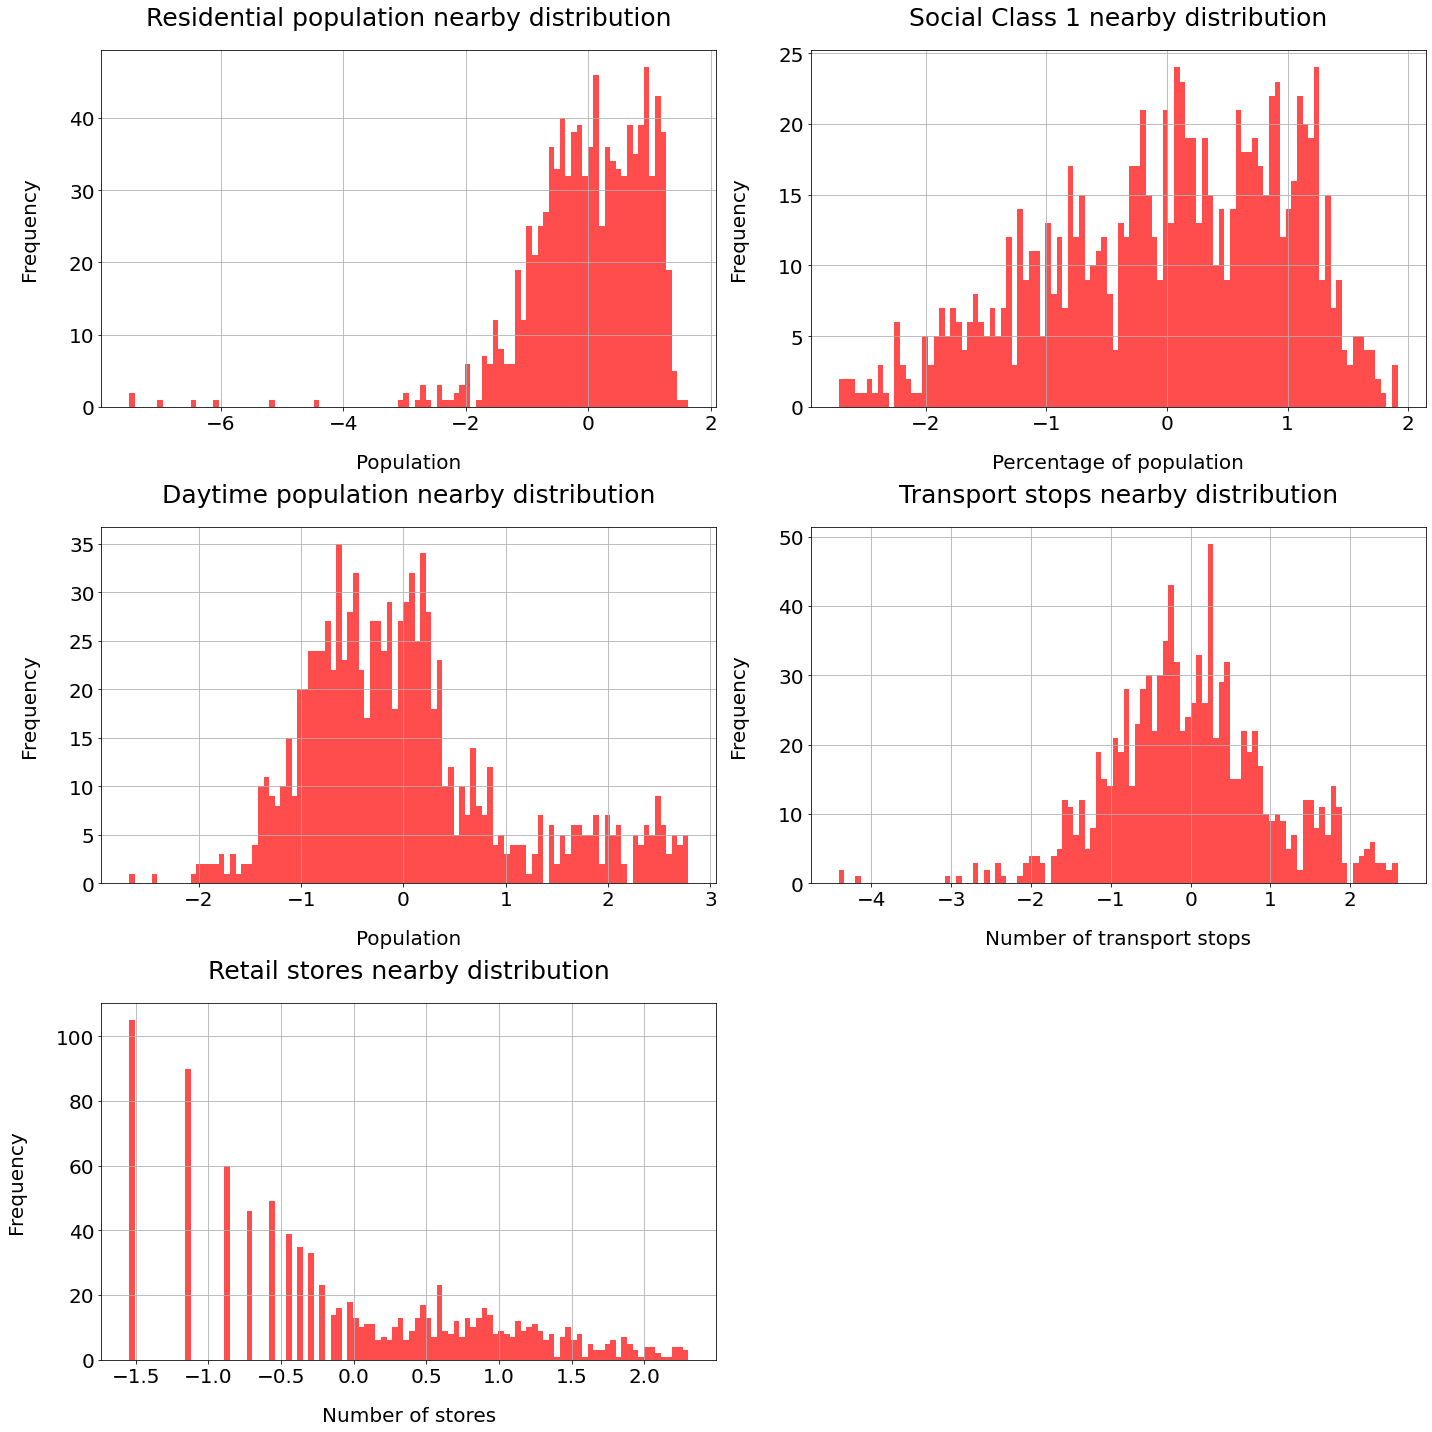

In [7]:
#create a base axis for teh plots
fig, ax = plt.subplots(3,2, figsize = (20,20))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(columns):
    
    #create the histogram using the column
    London_convenience_stores_scaled[col].hist(bins = 100, ax = axis[i],
                                       color = "red",
                                       alpha = 0.7)
    #add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20)

#remove the unused axis
axis[5].set_axis_off()
#keep the layout tight
plt.tight_layout()
#show the plot 

### 2) Perform Silhouette and Elbow Analysis

Using this transformed data, perform silhouette and elbow analysis on the data to find the optimal number of clusters to implement in the final model.

In [8]:
#import the necessary libraries
from sklearn import metrics
from sklearn.cluster import KMeans

#create an empty list
list_SSE = []
#set ther ange of clusters to evaluate
min_k = 1
max_k = 10
range_k = range(min_k, max_k)

#iterate over the range
for i in range_k:
    #perform the clustering algorithm
    km = KMeans(n_clusters = i,
               init = "random",
               n_init = 10,
               max_iter = 300,
               tol = 1e-04, 
                random_state = 22)
    #fit this to the data
    km.fit(London_convenience_stores_scaled[log_columns])
    #add the SEE score
    list_SSE.append(km.inertia_)    

In [10]:
#for the silhouette score
import random

#create an empty list
silhouette = []

#iteratre over the number of clusters to evaluate
for i in range(2,10):
    
    #create an empty list to hold the averages
    average = []
    #perform the clustering algorithm several times for each number of clusters
    for x in range(1,10):
        #set the number of clusters
        k_cluster = i
        #generate a arandom seed number
        random_seed = random.randint(1,101)
        #apply the KMeans clustering algorithm
        kmeans_method = KMeans(n_clusters = k_cluster,
                              random_state = random_seed)
        kmeans_method.fit(London_convenience_stores_scaled[log_columns])
        #extract the labels
        labels = kmeans_method.labels_
        #extract the silhouette score
        a = metrics.silhouette_score(London_convenience_stores_scaled[log_columns], labels)
        #append the result
        average.append(a)
    #clauclate the average silhouette score for each number of clusters 
    silhouette.append(sum(average)/len(average))

Text(0.5, 1.0, 'Kmeans Elbow plot')

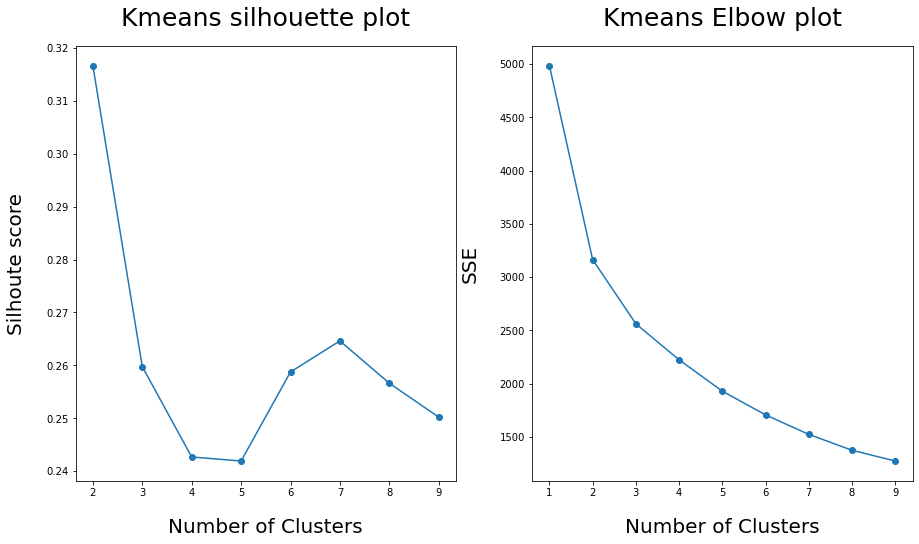

In [12]:
#combine both plots
fig, ax = plt.subplots(1,2, figsize = (15,8))

ax[0].plot(range(2,10), silhouette, marker = "o")
ax[0].set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax[0].set_ylabel("Silhoute score", fontsize =20, labelpad = 20)
ax[0].set_title("Kmeans silhouette plot", fontsize = 25, pad = 20)

ax[1].plot(range_k, list_SSE, marker = "o")
ax[1].set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax[1].set_ylabel("SSE", fontsize =20, labelpad = 20)
ax[1].set_title("Kmeans Elbow plot", fontsize = 25, pad = 20)


### 3) Select the most appropiate cluster number and check the results

Using the plots created above, which is the most appropriate number of clusters to implement on the dataset? Apply the model and check the results both in terms of the means of each clusters and the geographical interpretation. Create cluster names and descriptions for these:

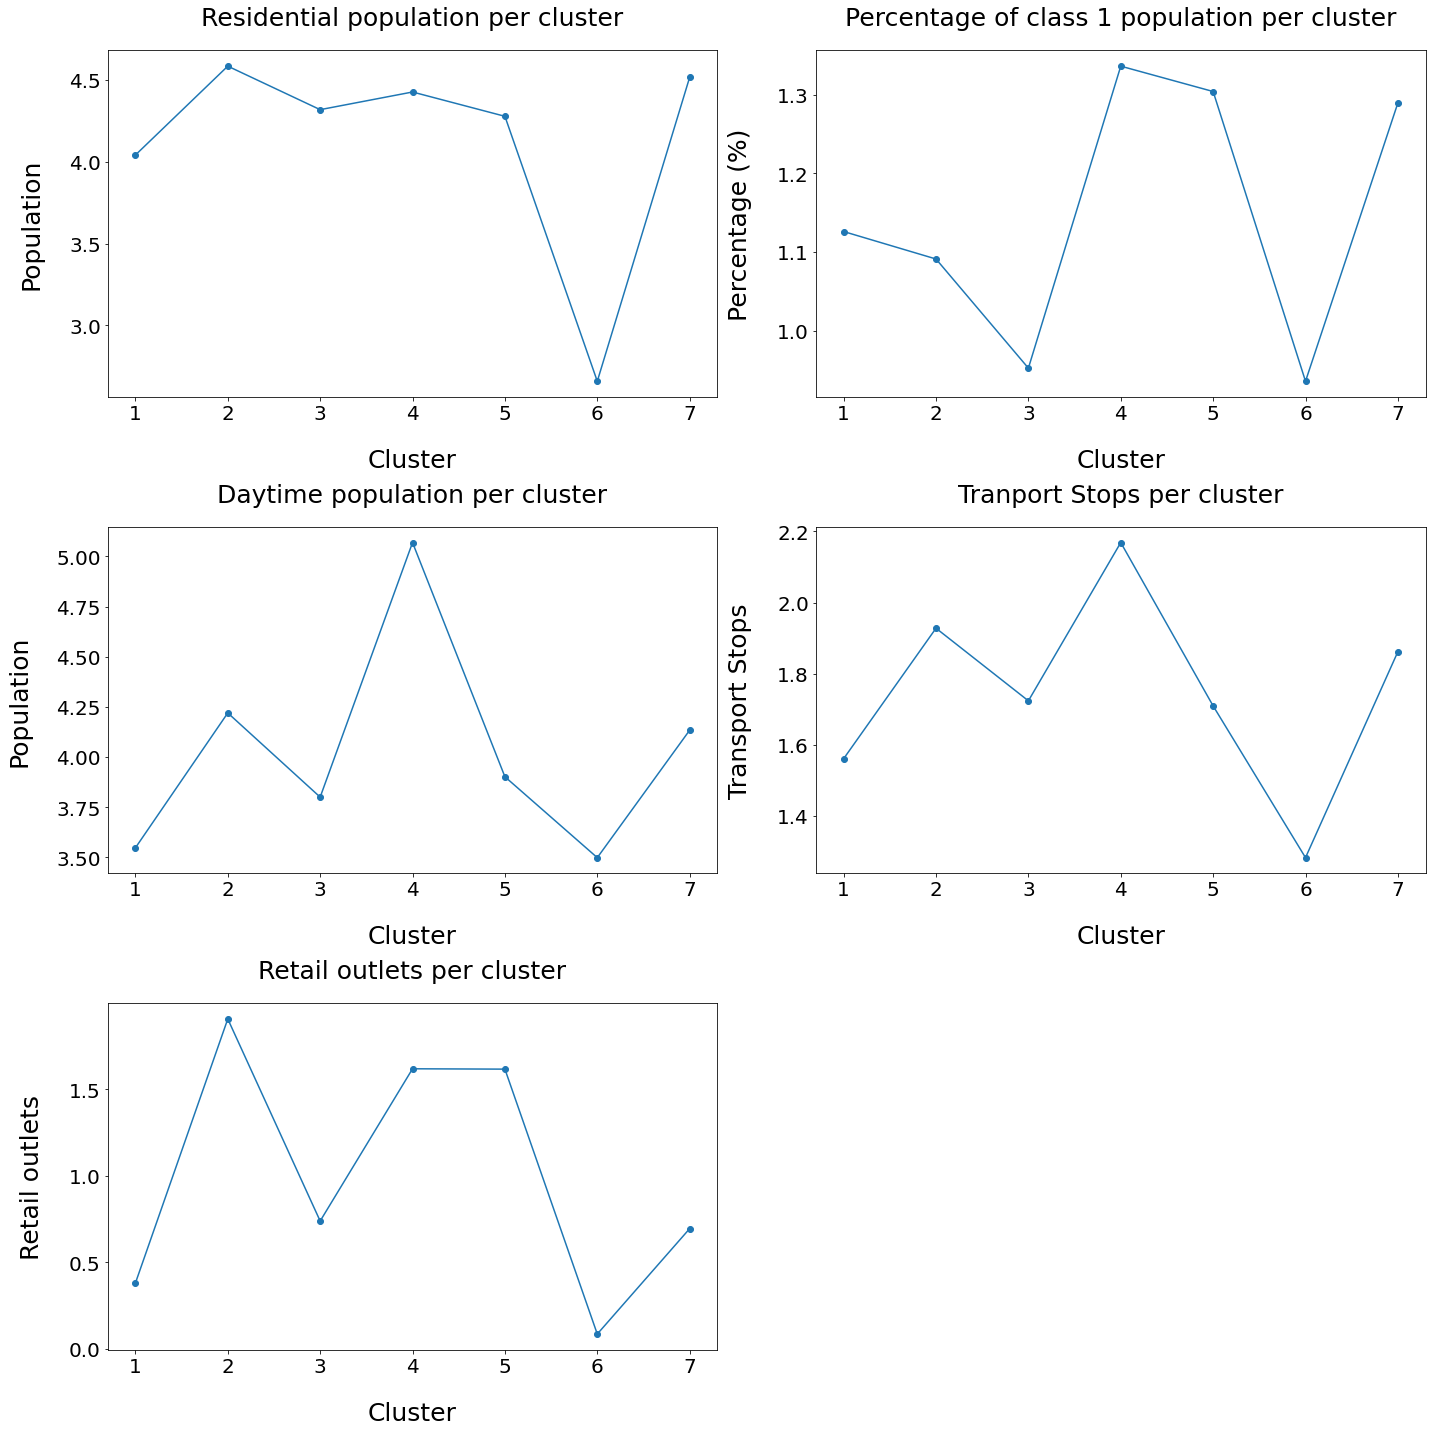

In [13]:
#perform the clustering with the chosen number of clusters
kmeans_method = KMeans(n_clusters = 7,
                        random_state = 22,
                      n_init = 10)
kmeans_method.fit(London_convenience_stores_scaled[log_columns])


#creating plots for the results to understand the means

#set the titles
titles = ["Residential population per cluster", 
         "Percentage of class 1 population per cluster",
         "Daytime population per cluster",
         "Tranport Stops per cluster",
         "Retail outlets per cluster"]
#set the labels
ylabels = ["Population",
          "Percentage (%)",
          "Population",
          "Transport Stops",
          "Retail outlets"]
#extract the cluster labels and add these back to teh data
labels = kmeans_method.labels_
London_convenience_stores["labels"] = labels
London_convenience_stores["labels"] = London_convenience_stores["labels"] + 1

#create a base plot
fig, ax = plt.subplots(3,2, figsize = (20,20))
#flatten the axis
axis = ax.flatten()

#iterate over each column to create plots for each 
for i, col in enumerate(columns):
    #create an empty dictionary
    col_dict = {}
    #iterate over each label
    for label in list(London_convenience_stores["labels"].unique()):
        #crete a new dataframe for each label
        label_df = London_convenience_stores[London_convenience_stores["labels"] == label]
        #add the mean to the dataframe
        col_dict[label] = label_df[col].mean()
    #convert the dictionary to a dataframe
    column_df = pd.DataFrame.from_dict(col_dict, orient = "index")
    #reset the index
    column_df.reset_index(inplace=True)
    #sort the values by the index
    column_df.sort_values(by = "index", inplace=True)
    
    #plot the results
    axis[i].plot(column_df["index"], column_df[0],
                marker = "o")
    
    #set the plots up
    axis[i].set_title(titles[i], fontsize = 25, pad = 25)
    axis[i].set_xlabel("Cluster", fontsize = 25, labelpad = 25)
    axis[i].set_ylabel(ylabels[i], fontsize =25, labelpad = 25)
    axis[i].tick_params(axis = "both", labelsize = 20)

#remove the unused axis
axis[5].set_axis_off()

#set the layout to tight so no overalp
plt.tight_layout()
    

In [14]:
#extract the number of stores within each 
London_convenience_stores["labels"].value_counts()

3    210
7    192
1    151
2    147
4    146
5    144
6      7
Name: labels, dtype: int64

In [15]:
#read in Output areas outline from the UK geodata store
#read in the output area shapefile
#extracted from the UK geo portal: https://geoportal.statistics.gov.uk/
London_outline = gpd.read_file("Data/London_outline.gpkg")

C:\Users\phili\anaconda3\envs\DSS\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


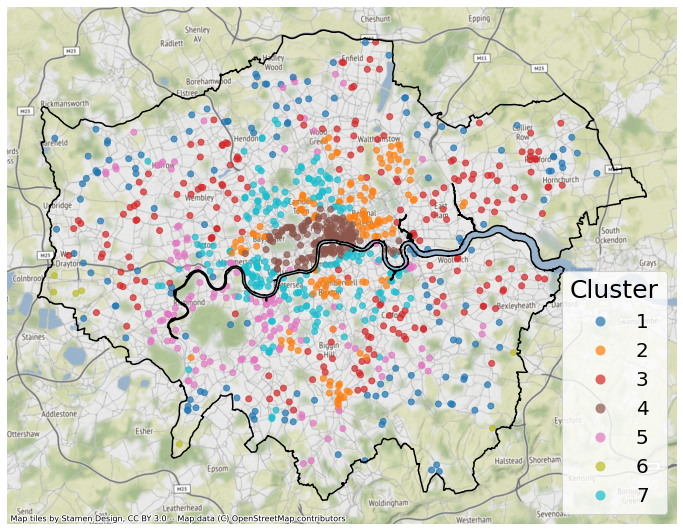

In [16]:
#create the base axis
fig, ax = plt.subplots(1,1, figsize = (12,12))

#plot the boundary
London_outline.boundary.plot(ax = ax,
                        color = "black")

#add the labels
London_convenience_stores.plot(column = "labels",
                   categorical = True,
                   legend = True,
                   ax = ax,
                   cmap = "tab10",
                   alpha = 0.7,
                   legend_kwds = {"title":"Cluster",
                                 "fontsize":"20",
                                 "title_fontsize":"25"})

#add the basemap
cx.add_basemap(crs = "EPSG:27700",
              ax = ax)

ax.set_axis_off()

Describe the clusters with both a name and a rough description:

Do these make sense to you?

What would you do differently?

How can you get better results?

## Coding Challenges

### Apply the model to a dataset of you choosing